# <b> active-pynference </b> : T-maze demo

Hello you ! This is a quick demo of the <b>active-pynference</b> / <b>actynf</b> package to simulate MDPs using Sophisticated Inference ! 
Buckle up buckaroo !


## 1. Introducing the task

To demonstrate the ability of the Sophisticated Inference algorithm to predict various behaviours in an explore/exploit environments, we will focus on a environment well known within the Active Inference community : the T-maze.

Let's picture a mouse in a simple maze :

![starting_situation.png](local_resources/tmaze/starting_situation.png)

This maze consists in two objects (here : a cheese and a mousetrap) that are either on the left or the right branch. The initial position of those objects is determined by the experimenter (you !). Formally, we can note $s_1$ the state relative to the position of the cheese (either left or right). The initial position of the cheese is determined by the following probability distribution : $D_1 = [p_{init},1-p_{init}]$ and will not change during a trial.

The mouse may be in four different places : on its starting position (0),on the bottom of the maze (1), on the left(2) or on the right (3). Let's call this second state $s_2$. Initially, the value of $s_2$ is always 0.

The mouse always wants to get to observe cheese as fast as possible and wants to stay away from observing the mousetrap. How much the mouse is looking after the reward and how much it fears the trap is fixed by the experimenter through preference parameters called *reward seeking* (rs)  and *loss aversion* (la).

**Note :** To discourage greedy mouses, once it has picked either left or right, it is stuck for the remainder of the trial. Therefore, the mouse only has one chance at guessing where the cheese is.

This wouldn't be a very interesting setup if we didn't add another dimension to the task : the clue. If the mouse chooses to get to the bottom of the maze, it will receive a clue. Although this clue has no extrinsic reward, it may (or may not) contain some relevant information regarding the position of the cheese. For example, if the clue is good, it will indicate reliably a certain value if the cheese is left and another if the cheese is right.If its not, the observation it provides the mouse will have no correlation with the position of the cheese whatsoever, making it useless. We can picture those clue observation values as arrows pointing towards the right or the left : 

Reliable clue                           | Unreliable clue                     
:--------------------------------------:|:------------------------------------:
![](local_resources/tmaze/goodclue.gif) |![](local_resources/tmaze/badclue.gif)

The point of this task is to explore how various parameters such as the mouse initial perception of the task or the environmental dynamics may affect its behaviour : *Should I get the clue,resolving uncertainty but differing my reward ? Should I risk going for the cheese even if I'm not sure about its position ? How good is the clue ?*

Casper Hesp and colleagues made this nice rendition of the paradigm (replace food with cheese and shock with mousetrap):

![](local_resources/tmaze/tmaze_article_figure_hesp.png)

<sub><sup>(**Source :** Hesp, Casper & Smith, Ryan & Parr, Thomas & Allen, Micah & Friston, Karl & Ramstead, Maxwell. (2019). Deeply Felt Affect: The Emergence of Valence in Deep Active Inference. 10.31234/osf.io/62pfd.)</sub></sup>

On the next part of this tutorial , we'll see how to simulate various mouse behaviours using *active_pynference*.

## 2 . Using the package

### a. Install the package & import the needed packages 
<sup><sub><b> active-pynference </b> requires Python 3.x. and has been tested for Python 3.11 + but probably works well enough with slightly older versions.</sub></sup>

You can install the package by running :

```
    pip install active-pynference
```

You can find more complete documentation regarding the package installation in the installation_instructions.ipynb file.

Now that the package is successfully installed, let's explore what we can do with it !

In [1]:
# First, let's import stuff !
# Python "classics": 
import os
import numpy as np
import matplotlib.pyplot as plt


# Active Inference based packages :
import actynf # import active-pynference package
print("Imported active-pynference - version " + actynf.__version__)

Imported active-pynference - version 0.1.30


### b. Set up the environment and the mouse model

The active-pynference package relies on a generic component to build both subject environments and models. This generic component is the <i> layer </i>.
Let's import it using :

In [2]:
from actynf.layer.model_layer import mdp_layer

In *actynf*, the **mdp_layer** is a generic Python class that can be used to compute observations from states and actions (a generative process) as well as infer states and actions from observations and model variables (a generative model). All the user has to do to differentiate between those behaviours is to specify it in the constructor.

Let's build the environment for our T-maze example :

In [3]:
def build_tmaze_process(pinit,pHA,pWin):
    """
    pinit : prob of reward initial position being left / right
    pHA : probability of clue giving the correct index position
    pWin : probability of winning if we are in the correct position

    This function returns a mdp_layer representing the t-maze environment.
    """
    print("T-maze gen. process set-up ...  ",end='')

    T = 3  # The trials are made of 3 timesteps (starting step + 2 others)

    # Initial situation
    d = [np.array([pinit,1-pinit])    ,np.array([1,0,0,0])]
    #  on which side is the cheese | where is the mouse 
    Ns = [arr.shape[0] for arr in d] # Number of states
    
    # Transition matrixes between hidden states=
    # a. Transition between cheese states --> the cheese doesn't move during the trial, and the mouse can't make it move :
    B_context_states = np.array([[[1],[0]],
                                 [[0],[1]]])
    # b. Transition between mouse position states --> 4 actions possible for the mouse
    B_behav_states = np.zeros((Ns[1],Ns[1],Ns[1]))

    # - 0 --> Move to start from any state
    B_behav_states[0,:,0] = 1          
    # - 1 --> Move to clue from start, else go to start
    B_behav_states[:,:,1] = np.array([[0,1,1,1],
                                      [1,0,0,0],
                                      [0,0,0,0],
                                      [0,0,0,0]])
    # - 2 --> Move to choose left from start or hint, else go to start
    B_behav_states[:,:,2] = np.array([[0,0,1,1],
                                      [0,0,0,0],
                                      [1,1,0,0],
                                      [0,0,0,0]])  
    
    # - 3 --> Move to choose right from start or hint, else go to start
    B_behav_states[:,:,3] = np.array([[0,0,1,1],
                                      [0,0,0,0],
                                      [0,0,0,0],
                                      [1,1,0,0]])  
    b = [B_context_states, B_behav_states]
    # Note : as you can see, the mouse can't go to right then left or left then right : every trial, it has to make a decision between the two.

    # Active Inference also revolves around a state-observation correspondance that we describe here :
    

    # 1. Mapping from states to observed hints, depending on cheese & mouse states
    #
    # [ .  . ]  No hint
    # [ .  . ]  Left Hint            Rows = observations
    # [ .  . ]  Right Hint
    # Left Right
    # Columns = cheese state
    A_obs_hints = np.zeros((3,Ns[0],Ns[1]))
    A_obs_hints[0,:,:] = 1
    A_obs_hints[:,:,1] = np.array([[0,0],
                             [pHA, 1-pHA],
                             [1-pHA,pHA]]) # We only get the clue if the mouse moves to state 1
    
    # 2. Mapping from states to outcome (win / loss / null), depending on cheese & mouse states
    #
    # [ .  . ]  Null
    # [ .  . ]  Win           Rows = observations
    # [ .  . ]  Loss
    # Left Right
    # Columns = cheese state
    A_obs_outcome = np.zeros((3,Ns[0],Ns[1]))
    A_obs_outcome[0,:,:2] = 1
    A_obs_outcome[:,:,2] = np.array([[0,0],   # If we choose left, what is the probability of achieving win / loss 
                             [pWin, 1-pWin],
                             [1-pWin,pWin]]) # Choice gives an observable outcome
                   # If true = left, right
    A_obs_outcome[:,:,3] = np.array([[0,0],     # If we choose right, what is the probability of achieving win / loss 
                                     [1-pWin, pWin],
                                     [pWin,1-pWin]]) # Choice gives an observable outcome
                  # If true = left, right
    
    # 3. Mapping from mouse position states to observed mouse position
    #
    # [ .  .  .  .] start
    # [ .  .  .  .] hint
    # [ .  .  .  .] choose left         Row = Behaviour state
    # [ .  .  .  .] choose right
    #  s   h  l  r
    #
    # 3rd dimension = observed behaviour
    # The 2nd dimension maps the dependance on cheese state (unvariant)
    A_obs_behaviour = np.zeros((Ns[1],Ns[0],Ns[1]))
    for i in range (Ns[1]) :
        A_obs_behaviour[i,:,i] = np.array([1,1])
    a = [A_obs_hints,A_obs_outcome,A_obs_behaviour]

    No = [ai.shape[0] for ai in a] # Number of outcomes

    # Finally, we set up the preferences of the environment (this is an environment, thus this is empty) ...
    c = [np.zeros((No[0],T)),np.zeros((No[1],T)),np.zeros((No[2],T))]
    # ... as well as the allowable transitions the mouse can choose :
    u = np.array([[0,0],[0,1],[0,2],[0,3]]).astype(int)
    
    # Habits
    e = np.ones((u.shape[0],))

    # The environment has been well defined and we may now build a mdp_layer using the following constructor : 
    layer = mdp_layer("T-maze_environment","process",a,b,c,d,e,u,T)
    #     mdp_layer(name of the layer,process or model, a,b,c,d,e,u,T)
    print("Done.")
    return layer

# We can test that the layer was well defined by instantiating and building it :
tmaze_environment = build_tmaze_process(0.5,1.0,1.0)
print(tmaze_environment)

T-maze gen. process set-up ...  Done.
LAYER T-maze_environment : 
 -------------------------------------
LAYER DIMENSION REPORT (T-maze_environment): 

Observation modalities : 3
    Modality 0 : 3 outcomes.
    Modality 1 : 3 outcomes.
    Modality 2 : 4 outcomes.
Hidden states factors : 2
    Model factor 0 : 2 possible states. 
    Model factor 1 : 4 possible states. 
Number of potential actions : 4
    Factor 0 : 1 possible transitions. 
    Factor 1 : 4 possible transitions. 
-------------------------------------

##################################################
Layer weights :
   Matrix a :
     Modality 0 :
[[[1. 0. 1. 1.]
  [1. 0. 1. 1.]]

 [[0. 1. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 1. 0. 0.]]]
     Modality 1 :
[[[1. 1. 0. 0.]
  [1. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 1. 0.]]]
     Modality 2 :
[[[1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]]]


As you can see, we can see a general overview of the layer we just defined. One advantage of using the same object for processes and models is that we can easily use the same object for both purposes if needed. Let's now define the model our mouse is going to entertain (don't worry, it'll be much quicker :) ) :

In [5]:

def build_mouse_model(true_process_layer,la,rs,T_horizon,
                      initial_clue_confidence = 0.1,action_selection_temperature = 32,mem_loss=0.0):
    """
    true_process_layer : the mdp_layer object where the tmaze environment has been defined
    la : how much the mouse is afraid of adverse outcomes (>0)
    rs : how much the mouse wants to observe cheese (>0)
    T_horizon : how much into the future the mouse will plan before picking its next action
    initial_clue_confidence : how much the mouse knows about the clue reliability
    """
    print("T-maze gen. model set-up ...  ",end='')
    T = 3

    #  The mouse knows where it stands in the maze initially, but it doesn't know where the cheese will spawn : this is something that
    # it will need to learn !
    d = [np.array([0.25,0.25]),np.array([1,0,0,0])]

    
    # Transition matrixes between hidden states ( = control states)
    b=[]
    for b_fac_proc in (true_process_layer.b):
        b.append(np.copy(b_fac_proc)*200)
    # The mouse knows how its action will affect the general situation. The mouse does not need
    # to learn that element . Be aware that too much uncertainty in some situations may prove hard to resolve for our
    # artifical subjects.


    a = []
    for a_mod_proc in (true_process_layer.a):
        a.append(np.copy(a_mod_proc)*200)
    a[0][:,:,1] = initial_clue_confidence*np.array([[0,0],
                                                    [0.25,0.25],
                                                    [0.25,0.25]])  
    # The mouse already knows how the cheese position and its own position in the 
    # maze relates relates to its probability to observe cheese. It also knows where
    # it is in the maze at all times. It knows this because it knows where it isn't ;)
    # However, the mouse still has to learn the reliability of the clue.


    # Finally, the preferences of the mouse are governed by the experimenter through the rs/la weights.
    No = [ai.shape[0] for ai in a]

    C_hints = np.zeros((No[0],T))
    C_win_loss = np.zeros((No[1],T))
    C_win_loss = np.array([[0,0,0],     #null
                           [0,rs,rs/2.0],  #win : as you can see, the mouse would much rather find the cheese at timestep 2 rather than 3. Feel free to play with this factor.
                           [0,-la,-la]]) #loss
    C_observed_behaviour = np.zeros((No[2],T))
    c = [C_hints,C_win_loss,C_observed_behaviour]
    # The mouse has no preference towards seeing a clue or being in a given position. However, it does have a preference regarding
    # the outcome of the trial (i.e. seeing the cheese or the mousetrap)
    
    # The allowable actions have been defined earlier
    u = true_process_layer.U
    # u = np.array([[0,0],[0,1],[0,2],[0,3]]).astype(int)
    
    # Habits
    e = np.ones((u.shape[0],))

    layer = mdp_layer("mouse_model","model",a,b,c,d,e,u,T,T_horiz=T_horizon)
    # This time, we define our layer as a "model" 

    # Here, we give a few hyperparameters guiding the beahviour of our agent :
    layer.hyperparams.alpha = action_selection_temperature # action precision : 
        # for high values the mouse will always perform the action it perceives as optimal, with very little exploration 
        # towards actions with similar but slightly lower interest

    layer.learn_options.eta = 1 # learning rate (shared by all channels : a,b,c,d,e)
    layer.learn_options.learn_a = True  # The agent learns the reliability of the clue
    layer.learn_options.learn_b = False # The agent does not learn transitions
    layer.learn_options.learn_d = True  # The agent has to learn the initial position of the cheese
    layer.learn_options.backwards_pass = True  # When learning, the agent will perform a backward pass, using its perception of 
                                               # states in later trials (e.g. I saw that the cheese was on the right at t=3)
                                               # as well as what actions it performed (e.g. and I know that the cheese position has
                                               # not changed between timesteps) to learn more reliable weights (therefore if my clue was
                                               # a right arrow at time = 2, I should memorize that cheese on the right may correlate with
                                               # right arrow in general)
    layer.learn_options.memory_loss = mem_loss
                                            # How many trials will be needed to "erase" 50% of the information gathered during one trial
                                            # Used during the learning phase
    print("Done.")
    return layer

mouse_model = build_mouse_model(tmaze_environment,2,3,3,1.0)
print(mouse_model)

T-maze gen. model set-up ...  Done.
LAYER mouse_model : 
 -------------------------------------
LAYER DIMENSION REPORT (mouse_model): 

Observation modalities : 3
    Modality 0 : 3 outcomes.
    Modality 1 : 3 outcomes.
    Modality 2 : 4 outcomes.
Hidden states factors : 2
    Model factor 0 : 2 possible states. 
    Model factor 1 : 4 possible states. 
Number of potential actions : 4
    Factor 0 : 1 possible transitions. 
    Factor 1 : 4 possible transitions. 
-------------------------------------

##################################################
Layer weights :
   Matrix a :
     Modality 0 :
[[[200.     0.   200.   200.  ]
  [200.     0.   200.   200.  ]]

 [[  0.     0.25   0.     0.  ]
  [  0.     0.25   0.     0.  ]]

 [[  0.     0.25   0.     0.  ]
  [  0.     0.25   0.     0.  ]]]
     Modality 1 :
[[[200. 200.   0.   0.]
  [200. 200.   0.   0.]]

 [[  0.   0. 200.   0.]
  [  0.   0.   0. 200.]]

 [[  0.   0.   0. 200.]
  [  0.   0. 200.   0.]]]
     Modality 2 :
[[[200. 

Now that we have defined our environment (generative process) and the model our mouse will entertain (generative model), we need to describe how the two will interact to form a system. 

To create interactions between layers, we need to establish *links* between some of their inputs and outputs :
- The environment outputs (outcomes) are forwarded to the mouse sensory states (observations)
- The mouse actions (active states) lead to a changes in the environment

In [8]:
from actynf import link # Let's import the "link" component to connect layers between one another !

#1. Create a link from observations generated by the environment to the mouse sensory states :
mouse_model.inputs.o = link(tmaze_environment, lambda x : x.o)
  #     the layer from which we get the data | the function extracting the data

#2. Create a link from the actions selected by the mouse to the t-maze environment :
tmaze_environment.inputs.u = link(mouse_model,lambda x : x.u)

After this step, we have designed the following construction :

![tmaze_network](local_resources/tmaze/tmaze_network.png)

<sup><sub>Note that in this situation, the mouse model of the maze is very close to the true environment. However, as long as the sizes of the *linked* dimensions (here "mouse_model.u-tmaze_environment.u" and "mouse_model.o-tmaze_environment.o") match, one could link very different layers.</sub></sup>

To use the resulting interconnected system, we will need a dedicated *actynf* object called a *network*.

*actynf* uses the *network* class to encapsulate *mdp_layers* and their *links*. When the network has been defined, we wil be able to run the whole thing !

In [6]:
from actynf.architecture.network import network

tmaze_net = network([tmaze_environment,mouse_model],"t-maze_network")
print(tmaze_net)

# For future use, let's also create a function that builds the whole network from scratch using the previously explicited set of parameters :
def build_tmaze_network(pinit,pHA,pWin,la,rs,T_horizon,initial_clue_confidence,action_selection_temp=32,memory_loss=0.0,
                            name="t-maze_network"):
    
    process_layer = build_tmaze_process(pinit,pHA,pWin)
    model_layer = build_mouse_model(process_layer,la,rs,T_horizon,
                                    initial_clue_confidence,action_selection_temp,memory_loss)

    mouse_model.inputs.o = link(tmaze_environment, lambda x : x.o)
    tmaze_environment.inputs.u = link(mouse_model,lambda x : x.u)

    return network([process_layer,model_layer],name)

___________________________________________________
LAYER NETWORK t-maze_network : 
___________________________________________________
   LAYERS:
    - T-maze_environment
    - mouse_model
   LINKS:
    - Layer link << T-maze_environment ---> mouse_model  >> along field : 
	    + o (0, 1, 2) --> o (0, 1, 2)
    - Layer link << mouse_model ---> T-maze_environment  >> along field : 
	    + u (0,) --> u (0,)
___________________________________________________



### c. Running simulations with the network

In [7]:
# Run our network for a single trial : 
print("One trial")
tmaze_net.run()
# # Or for multiple trials : (careful, this is the same object, meaning that the mouse model at the start of the 10 trials will be based on its previous experience during the one trial !)
# N = 10
# print(str(N) + " trials")
# tmaze_net.run_N_trials(10)

One trial
 Network [t-maze_network] : Timestep 3 / 3
 Done !   -------- (seeds : [3281-0;8720-0])


#### Note : seeding
*actynf* is based on Markov Decision Processes which rely heavily on random samplings :
-  for generative processes, during states transition and observations generation
-  for generative models, during the action selection (and possibly during the planning phase on the modified Sophisticated Inference algorithm)
To ensure our ability to reproduce the results of each trial, we use pseudo-random number generators. 

Using seeds, we can ensure that samplings will always lead to the same results. Here, the seed of the last generation as well as the number of successive trials done with this seed are shown :

``` >> (seeds : [layer_0_seed-trials_since_seeding;layer_1_seed-trials_since_seeding])```

You may (re)seed a layer or a network using the reseed function : 
``` 
> my_layer.reseed(new_seed[optional])
> my_network.reseed(new_seed[optional])
```
<sup><sub>If you dont provide a new seed, the layer will just reinitialize the random number generator.</sub></sup>


#### Note : accessing the results of simulations

*actynf* *layers* save the results of the last trial's computations in their **Short Term Memory (STM)**. This is useful during inference, learning and inspection.

STM stores two types of values:
- **Definite variables :** fixed values that are perceived as having definetely happened ; *observations (o) , states(x) and actions(u).*
- **Distributions :** probability distributions, noted computationally using the suffix "_d". Those are multidimensional matrices that represent joint probability distributions over a set of states/observations/action selection (usually posterior estimates, but may also be generative ditributions) ; *observations (o_d) , states(x_d) and actions (u_d).*

<sup><sub>*actynf* uses distributions rather than definite outcomes for all computations (generate observations/state transitions/perception). As an example, if the generative process layer outputs a specific set of observations for a given timestep ```o``` (say, $o_{t=1} = [2,0,1]$), it will automatically be converted to a multidimensionnal joint probability distribution ```o_d``` (in this case, a 3x3x4 matrix where all weights are 0.0 except for the one with (Python) coordinates [2,0,1] with weight 1.0). </sub></sup>

You can manually check the content of a layer's short term memory :
- Through  the layer object directly : ```> result_stm = tmaze_environment.STM ```
- Through the *network* layer components : ```> result_stm = tmaze_net.layers[0].STM ```
- Through the run method(s) of the *network* : ```> result_stm = tmaze_net.run(return_STMs=True) ```

**Warning /!\ :** Each time time a layer starts a new trial, a new STM object is generated. Therefore, you can't just use a STM "pointer" that you keep across several trials. Instead, you should collect STMs after each trial iteration (or use the "return_STMs" option in the *network.run_N_trials* method to gather all the generated STMs).

You can then extract relevant variables from this STM object : ```o = result_stm.o ; o_d = result_stm.o_d #etc...```

In [8]:
# Let's check the results of the previous run :
tmaze_environment_STM = tmaze_net.layers[0].STM
mouse_model_STM = tmaze_net.layers[1].STM

# Example : let's see how the mouse perception of the cheese position changed during the last trial !
print("Here are the results of the previous run for the mouse perception of the cheese position ! ")
# This is what the mouse infered as hidden states :
joint_state_perception = (mouse_model_STM.x_d) # x_d has dimensions Nstates_factor_1 x Nstates_factor_2 x ... x Nstates_factor_n x T
# And this is the true state distribution :
true_state_distribution = tmaze_environment_STM.x_d

# To marginalize this joint distribution over the axis of the cheese position (0), we just need to sum over the other state dimensions !
marginalized_mouse_model_of_cheese = np.sum(joint_state_perception, (1,))
marginalized_true_side_of_cheese = np.sum(true_state_distribution, (1,))
possible_cheese_position = ["left","right"]  # Not yet any implemented support for labels :/
for cheese_pos_idx in range(len(possible_cheese_position)):
    print("    Perception of cheese on the " + possible_cheese_position[cheese_pos_idx] + " across time : " + str(marginalized_mouse_model_of_cheese[cheese_pos_idx,:]) + " ( True values : " + str(marginalized_true_side_of_cheese[cheese_pos_idx,:]) + " ).")

Here are the results of the previous run for the mouse perception of the cheese position ! 
    Perception of cheese on the left across time : [0.5 0.5 0. ] ( True values : [0. 0. 0.] ).
    Perception of cheese on the right across time : [0.5 0.5 1. ] ( True values : [1. 1. 1.] ).


*(You may notice that the mouse is very naive about the cheese position, even after seing it at the last timestep : it does not reminisce about the cheese position in timesteps 0 & 1. This can be changed by using some form of "backward pass" to update those posteriors given the new information obtained and the knowledge about the actions performed. We implemented this sort of algorithm during subject learning. The result of this backward pass is available in the STM's "x_smoothed_d" variable)*

### d. Plotting nice figures :D

Let's generate a bunch of data and make nice plots !
To generate data for each set of parameters, let's use the functions we defined above and wrap them in a single function that generates numpy arrays of simulated data for several trials depending on a large number of parameters !

In [9]:
from actynf.base.function_toolbox import normalize

def generate_data(N,pinit,pHA,pWin,la,rs,T_horizon,initial_clue_confidence,
                  Nswitch=100,pinit2=1.0,
                  action_selection_temp=32,memory_loss=0.0,
                  return_ds = False,verbose=False):
    T = 3
    # Build our network
    network_tmaze = build_tmaze_network(pinit,pHA,pWin,la,rs,T_horizon,initial_clue_confidence,action_selection_temp,memory_loss,name="t-maze_network")
    
    # Initialize a few arrays to store the results of our simulations
    true_cheese_state = np.zeros((T,N))
    true_mouse_state = np.zeros((T,N))
    clue_observations = np.zeros((T,N))

    mouse_cheese_perception = np.zeros((2,T,N))
    mouse_actions = np.zeros((T-1,N))
    mouse_action_posterior = np.zeros((4,T-1,N))

    if return_ds :
        cheese_starting_pos = np.zeros((2,N+1))
        cheese_starting_pos_perception = np.zeros((2,N+1))
        cheese_starting_pos[:,0] = network_tmaze.layers[0].d[0]
        cheese_starting_pos_perception[:,0] = normalize(network_tmaze.layers[1].d[0])
    
    for trial_idx in range(N):
        # We can change the paradigm mid-simulation to explore how the agent would react !
        # If Nswitch > N, the switch never happens !
        if trial_idx == Nswitch:
            network_tmaze.layers[0].d[0] = np.array([pinit2,1-pinit2])
        

        # Run the simulation for trial_idx
        network_tmaze.run(verbose=verbose)
        
        # 1.Fetch the layers memories for this idx : 
        tmaze_environment_stm = network_tmaze.layers[0].STM
        mouse_model_stm =  network_tmaze.layers[1].STM

        # 2.a. Save some environment variables
        clue_observations[:,trial_idx] = tmaze_environment_stm.o[0,:]
        true_cheese_state[:,trial_idx] = tmaze_environment_stm.x[0,:]
        true_mouse_state[:,trial_idx] = tmaze_environment_stm.x[1,:]        

        # 2.b. Save some mouse model variables
        mouse_cheese_perception_for_this_trial = np.sum(mouse_model_stm.x_d,axis = 1)
        mouse_cheese_perception[:,:,trial_idx] = mouse_cheese_perception_for_this_trial
        mouse_actions[:,trial_idx] = mouse_model_stm.u
        mouse_action_posterior[:,:,trial_idx] = mouse_model_stm.u_d

        if return_ds :
            cheese_starting_pos[:,trial_idx+1] = network_tmaze.layers[0].d[0]
            cheese_starting_pos_perception[:,trial_idx+1] = normalize(network_tmaze.layers[1].d[0])

    if return_ds:
        return true_cheese_state,true_mouse_state,clue_observations,mouse_cheese_perception,mouse_actions,mouse_action_posterior,cheese_starting_pos,cheese_starting_pos_perception
    return true_cheese_state,true_mouse_state,clue_observations,mouse_cheese_perception,mouse_actions,mouse_action_posterior
        

# We can see what it outputs : 
# print(generate_data(1,0.5,0.8,1,1,2,2,1))

Now, let's import a few functions that help us plot animations / graphs of the various results !

In [10]:
# To generate animation gifs : 
print(actynf.__version__)
from actynf.demo_tools.tmaze.plot import tmaze_drawer

def draw_and_save_tmaze_gif(N = 30,pinit = 0.85,pHA = 1.0,
        pWin = 0.98,la = 2,rs = 3,T_horizon = 2,initial_clue_confidence = 1.0):
    ressources_path = os.path.join("ressources/tmaze")
    drawer = tmaze_drawer(ressources_path)
        # The drawer is a class that allows us to draw a set of
        # pictures of the maze ! All we need are the indicators 
        # generated by the "generate_data" function defined before

    true_cheese_state,true_mouse_state,clue_observations,mouse_cheese_perception,mouse_actions,mouse_action_posterior = generate_data(N,pinit,pHA,pWin,la,rs,T_horizon,initial_clue_confidence)
    my_gif = []
    for trial in range(N):
        print("Trial " + str(trial+1) + " / " + str(N))
        true_reward_state = true_cheese_state[:,trial]
        true_agent_state = true_mouse_state[:,trial]
        cheese_perception = mouse_cheese_perception[:,:,trial]
        clue_obs = clue_observations[:,trial]
        imglist = drawer.get_trial_mazeplot(trial+1,N,
                              15,true_reward_state,true_agent_state,
                              cheese_perception,clue_obs,
                              None,None)
        my_gif += imglist
    my_gif[0].save("ressources/tmaze/renders/render.gif", save_all=True, append_images=my_gif[1:],duration=30,loop=0)

0.1.5


ModuleNotFoundError: No module named 't_maze_test'

Reliable clue, random environment       | Reliable clue , environment stabilizes after trial 10 | Unreliable clue & random environment
:--------------------------------------:|:------------------------------------:|:------------------------------------:
![Image1](local_resources/tmaze/renders/render_good_clue_2.gif) |![Image2](local_resources/tmaze/renders/render_good_clue_cheese_stabilizes_at_10.gif)|![Image3](local_resources/tmaze/renders/render_bad_clue_random_env.gif)
$p_{init} = 0.5$ , $pHA = 1.0$|$p_{init} = 0.5$ for the first 10 trials, then $p_{init} = 0.05$ , $pHA = 1.0$|$p_{init} = 0.5$ , $pHA = 0.5$


Finally, let's plot the behaviour of our mouze on a "classic" matplotlib figure !

T-maze gen. process set-up ...  Done.
T-maze gen. model set-up ...  Done.
Established layerLink between T-maze_environment and mouse_model.
Established layerLink between mouse_model and T-maze_environment.
Simulations completed : drawing the figure !


C:\Users\annic\AppData\Local\Temp\ipykernel_25272\2465444930.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  myfig.show()


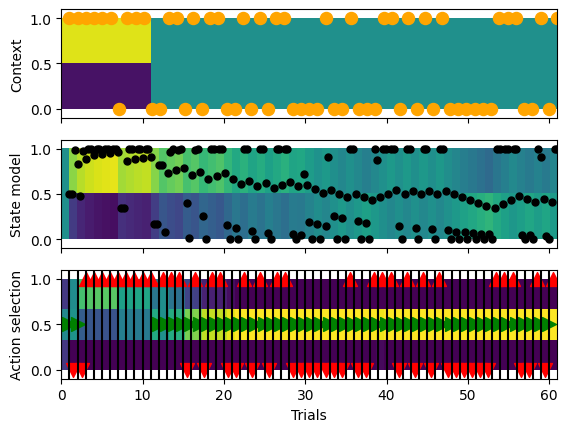

In [ ]:

# SIMULATE BEHAVIOUR AND PLOT (MATPLOTLIB)
def example_tmaze_plot(N = 60,pinit = 0.5,
                       Nswitch = 10,pinit2 = 0.85,
                        pHA = 1.0,pWin = 0.98,la = 2, rs = 3,
                        Thorizon = 2,initial_conf = 0.5,
                        action_selection_temp=32,memory_loss=0.0):
    """ Plotting tmaze simulation results on a matplotlib figure :
    - N : how many trials to simulate
    - pinit : Initial cheese side
    - Nswitch : trial at which the paradigm will switch. If Nswitch > N, the paradigm will not change
    - pinit2 : Cheese side after the eventual switch
    - pHA : P of clue showing the cheese side
    - pWin : P of reward if you get the cheese side
    - la : loss aversion, how much the mouse want to avoid the trap
    - rs : reward seeking, how much the mouse seeks after the cheese
    - Thorizon : how long into the future does the mouse look when planning its next action
    - initial_conf : how confident is the mouse about its belief in the clue
    - action_selection_temp : the higher this parameter, the more reluctant the agent will be to try a-priori suboptimal actions
    - memory_loss : how much previous information is forgotten when learning new information
    """
    
    # Simulate our data and store the results in a few arrays
    true_cheese_state,true_mouse_state,clue_observations,mouse_cheese_perception,mouse_actions,mouse_action_posterior,starting_cheese_position,perceived_starting_cheese_position = generate_data(N,pinit,pHA,pWin,la,rs,Thorizon,initial_conf,Nswitch,pinit2,action_selection_temp,memory_loss,True,verbose=False)
    print("Simulations completed : drawing the figure !")
    fig,axes = plt.subplots(3,sharex=True)
    

    infer_model = np.zeros((N*3,))
    for i in range(N):
        infer_model[i*3:(i*3+3)] = mouse_cheese_perception[0,:,i]
    img_act = mouse_action_posterior[1:,0,:]
    img_act[[0, 1, 2],:] = img_act[[1, 0, 2],:]


    markersize=100
    axes[0].imshow(starting_cheese_position,aspect='auto',interpolation='nearest',extent=[0,N+1,0,1],vmin=0,vmax=1)
    axes[0].scatter(np.linspace(1,N+1,N),1.0-true_cheese_state[0,:],color='orange',marker=".",s=3*markersize)
    
    axes[1].scatter(np.linspace(1,N+1,3*N),(infer_model),color='black',marker=".",s=markersize)
    axes[2].axvline(0,color='black')

    for trial in range(mouse_actions.shape[1]) :
        axes[2].axvline(trial+1,color='black')
        
    for trial in range(mouse_actions.shape[1]) :
        pos = 0
        t = 0
        acts = mouse_actions[:,trial]
        for act in acts :
            if (t==0): # First timestep :
                if (act==1):
                    axes[2].scatter([trial+1+pos],[0.5],color='green',marker='>',s=markersize)
                elif (act==0):
                    axes[2].scatter([trial+1+pos],[0.5],color='orange',marker='<',s=markersize)

            if (act==2):
                axes[2].scatter([trial+1+pos],[1],color='red',marker='^',s=markersize)
                break
            elif (act==3):
                axes[2].scatter([trial+1+pos],[0],color='red',marker='v',s=markersize)
                break
            pos = pos + 0.5
            t = t +1
    
    axes[2].imshow(img_act,aspect='auto',interpolation='nearest',extent=[0,N+1,0,1],vmin=0,vmax=1)
    axes[1].imshow(perceived_starting_cheese_position,aspect='auto',interpolation='nearest',extent=[0,N+1,0,1],vmin=0,vmax=1)


    for ax in axes:
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0,N+1])
    axes[0].set_ylabel("Context")
    axes[1].set_ylabel("State model")
    axes[2].set_ylabel("Action selection")
    axes[2].set_xlabel("Trials")
    return fig



myfig = example_tmaze_plot(60,pinit=0.95,Nswitch=10,pinit2=0.5,pHA=0.85,action_selection_temp=32,memory_loss=0)
myfig.show()
# myfig.savefig(os.path.join("local_resources/tmaze/renders"

### How to read this ?

![Tutorial read the plot](./local_resources/tmaze/read_the_plot.png)


### A few cool plots !

Remember the gifs we generated earlier ? These are plots with the same parameters !

1. Reliable clue, random environment       | 2. Reliable clue , environment stabilizes after trial 10 | 3. Unreliable clue & random environment
:--------------------------------------:|:------------------------------------:|:------------------------------------:
![Image1](local_resources/tmaze/renders/render_good_clue.png) |![Image2](local_resources/tmaze/renders/render_good_clue_cheese_stabilizes_at_10.png)|![Image3](local_resources/tmaze/renders/render_bad_clue_random_env.png)
$p_{init} = 0.5$ , $pHA = 1.0$|$p_{init} = 0.5$ for the first 10 trials, then $p_{init} = 0.05$ , $pHA = 1.0$|$p_{init} = 0.5$ , $pHA = 0.5$

And here are a few other examples if we play with some of the other parameters !

4. Brutal paradigm shift, no memory loss       | 5. Brutal paradigm shift, with memory loss | 6. A paradigm shift with noiser action selection
:--------------------------------------:|:------------------------------------:|:------------------------------------:
![Image1](local_resources/tmaze/plot_paradigm_shift.png)|![Image3](local_resources/tmaze/plot_paradigm_shift_memory_loss.png) |![Image2](local_resources/tmaze/plot_paradigm_shift_noisy_selection.png)
$p_{init} = 0.0$ for the first 10 trials, then $p_{init} = 0.5$ , $pHA = 1.0$|Same as on the left, but with the memory loss parameter set to 10. |The action_selection_temp has been set to 5 instead of the usual 32, 


#### Parameters for the previous simulations :

**action_selection_temp :** (the Active Inference $\alpha$ parameter.) The higher its value, the more detemrinistic the agent will be when selecting an action from the perceived action poster, making it less likely that the agent will explore seemingly suboptimal solution.
